In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

np.random.seed(100)

# Parameters
S0 = 100
K = 100
T = 1
r = 0.05
sigma = 0.2
barrier = 120
num_paths = 1000
num_steps = 100
S0_values = np.linspace(80, 120, 20)


In [2]:
def call_up_and_out(S, K, T, r, sigma, B, num_steps, num_paths, num_obs):
    dt = T / num_steps
    total_payoff = 0.0
    obs = np.round(np.linspace(1, num_steps + 1, num_obs))

    for _ in range(num_paths):
        path = np.zeros((num_steps + 1, ))
        path[0] = S

        for i in range(1, num_steps + 1):
            z = np.random.standard_normal()
            path[i] = path[i - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)

            if i in obs and path[i] > B:
                break

        payoff = max(path[-1] - K, 0)
        total_payoff += payoff

    option_price = np.exp(-r * T) * (total_payoff / num_paths)

    return option_price

def call_european(T, K, r, S, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * stats.norm.cdf(d1) - K * np.exp(-r * T) * stats.norm.cdf(d2)

In [3]:
S0_values = np.linspace(0, 120, 30)

In [4]:
option_prices = call_european(T, K, r, S0_values, sigma)
option_prices_b = np.zeros(len(S0_values))

for i, S0 in enumerate(S0_values):
  option_prices_b[i] = call_up_and_out(S0, K, T, r, sigma, barrier, num_paths, num_steps, num_obs=num_steps)

<ipython-input-2-b11a8a40b551>:25: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


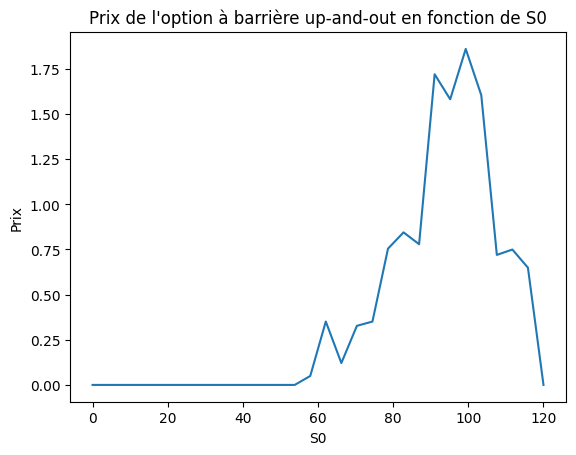

In [5]:
plt.plot(S0_values, option_prices_b)
plt.xlabel("S0")
plt.ylabel("Prix")
plt.title("Prix de l'option à barrière up-and-out en fonction de S0")
plt.show()

Comme attendu, le payoff d'une option barrière up-and-out est bien différent d'un call européen. En effet, nous remarquons ici que le prix de cette option est maximale pour S0 proche de K. Cela fait sens car nous nous rapprochons de la barrière B>K sans pour autant prendre trop de risque d'atteindre B. Ensuite, le prix chute jusqu'à atteindre 0 en S0=B.

In [6]:
def call_lookback_floating_strike(S0, T, r, sigma, num_paths, num_steps, num_obs):
    dt = T / num_steps
    obs = np.round(np.linspace(1, num_steps + 1, num_obs))
    option_prices = []


    for _ in range(num_paths):
        S = S0
        max_price = S0

        for i in range(num_steps):
            z = np.random.normal()
            S *= np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt)* z)

            if i in obs:
              max_price = max(max_price, S)

        payoff = max(max_price - S, 0)

        option_price = payoff * np.exp(-r * T)
        option_prices.append(option_price)
    return np.mean(option_prices)


S0_values = np.linspace(80, 120, 20)
option_prices_f = np.zeros(len(S0_values))

for i, S0 in enumerate(S0_values):
  option_prices_f[i] = call_lookback_floating_strike(S0, T, r, sigma, num_paths, num_steps, num_obs=num_steps)


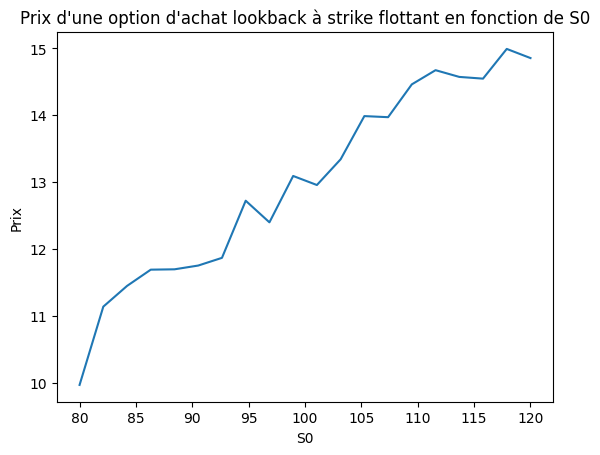

In [7]:
plt.plot(S0_values, option_prices_f)
plt.xlabel("S0")
plt.ylabel("Prix")
plt.title("Prix d'une option d'achat lookback à strike flottant en fonction de S0")
plt.show()

Le payoff d'une option lookback à strike flottant est également bien différent de celui d'une option européenne. Néanmoins, nous pouvions nous attendre à ce genre de profil linéaire. En effet, l'option sera toujours exercée car S_max > =ST. Si S_max est atteint lors de la vie de l'option c'est à dire à t!=T. Alors cela équivaut à se retrouver sur la partie strictement positive du payoff d'une option européenne.

In [8]:
def simulate_maximum(S_T, t, n_simulations):
    U = np.random.uniform(low=0, high=1, size=n_simulations)
    M_T = (S_T + np.sqrt(S_T**2 - 2 * sigma**2 * t * np.log(U)))/2
    return M_T

def call_up_and_out_continuous(S0, K, B, T, r, sigma, n_simulations):
    dt = T
    Z = np.random.normal(0, 1, n_simulations)
    S_T = S0 * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    M_T = simulate_maximum(np.log(S_T/S0), dt, n_simulations)

    crossed_barrier = M_T >= np.log(B/S0)
    payoff = np.where(~crossed_barrier, np.maximum(S_T - K, 0), 0)

    option_price = np.exp(-r * T) * np.mean(payoff)
    return option_price

def call_lookback_floating_strike_continuous(S0, T, r, sigma, n_simulations):
    dt = T
    Z = np.random.normal(0, 1, n_simulations)
    S_T = S0 * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    M_T = simulate_maximum(np.log(S_T/S0), dt, n_simulations)

    payoff = np.maximum(np.exp(M_T)*S0 - S_T, 0)

    option_price = np.exp(-r * T) * np.mean(payoff)
    return option_price

In [9]:
S = 100
num_paths = 200
num_steps = 1000
obs_values = np.logspace(0.5, 3, num=50, endpoint=True, base=10.0, dtype=None, axis=0)

call_european_barrier_discrete = np.zeros(len(obs_values))
call_european_barrier_continuous = call_up_and_out_continuous(S, K, barrier, T, r, sigma, num_steps).repeat(len(obs_values))

for i, obs in enumerate(obs_values):
    call_european_barrier_discrete[i] = call_up_and_out(S, K, T, r, sigma, barrier, num_paths, num_steps, int(obs))

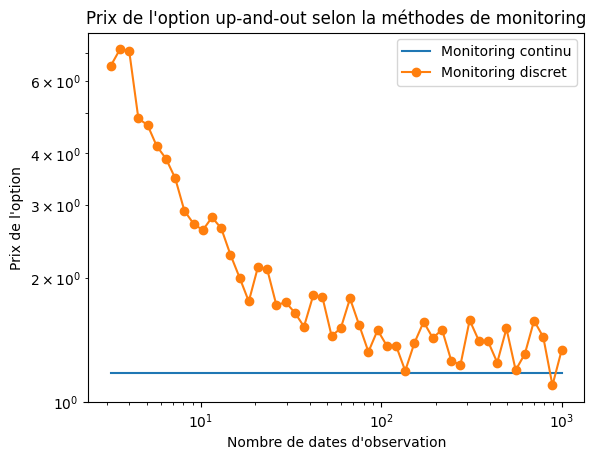

In [10]:
plt.plot(obs_values, call_european_barrier_continuous, label='Monitoring continu')
plt.plot(obs_values, call_european_barrier_discrete, marker='o', linestyle='-', label='Monitoring discret')
plt.yscale("log")
plt.xscale("log")
plt.xlabel('Nombre de dates d\'observation')
plt.ylabel('Prix de l\'option')
plt.title("Prix de l\'option up-and-out selon la méthodes de monitoring")
plt.legend()
plt.show()

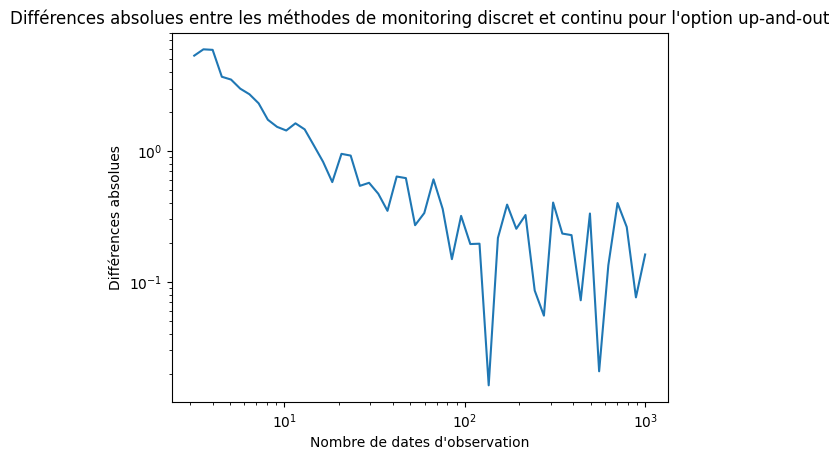

In [11]:
differences = np.abs(call_european_barrier_discrete - call_european_barrier_continuous)
plt.plot(obs_values, differences)
plt.yscale("log")
plt.xscale("log")
plt.xlabel('Nombre de dates d\'observation')
plt.ylabel('Différences absolues')
plt.title("Différences absolues entre les méthodes de monitoring discret et continu pour l\'option up-and-out")
plt.show()

La convergence du prix Monte Carlo de l’option d’achat à barrière up-and-out quand le nombre de dates d’observation augmente vers le prix Monte Carlo avec monitoring continu de la barrière est bien respectée.

In [12]:
lookback_floating_strike_discrete = np.zeros(len(obs_values))
lookback_floating_strike_continuous = call_lookback_floating_strike_continuous(S, T, r, sigma, num_steps).repeat(len(obs_values))
for i, obs in enumerate(obs_values):
    lookback_floating_strike_discrete[i] = call_lookback_floating_strike(S, T, r, sigma, num_paths, num_steps, int(obs))

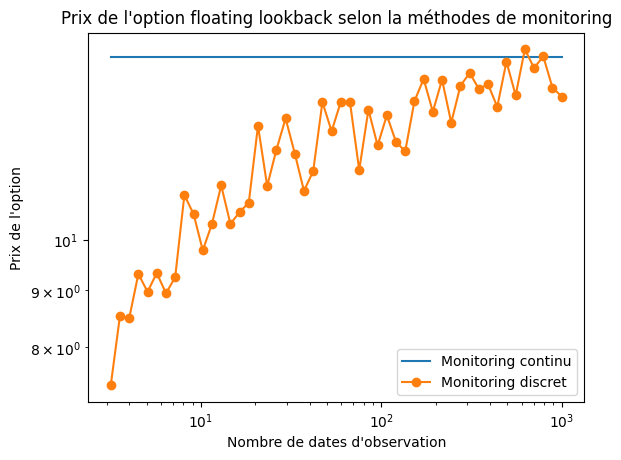

In [13]:
plt.plot(obs_values, lookback_floating_strike_continuous, label='Monitoring continu')
plt.plot(obs_values, lookback_floating_strike_discrete, marker='o', linestyle='-', label='Monitoring discret')
plt.yscale("log")
plt.xscale("log")
plt.xlabel('Nombre de dates d\'observation')
plt.ylabel('Prix de l\'option')
plt.title("Prix de l\'option floating lookback selon la méthodes de monitoring")
plt.legend()
plt.show()

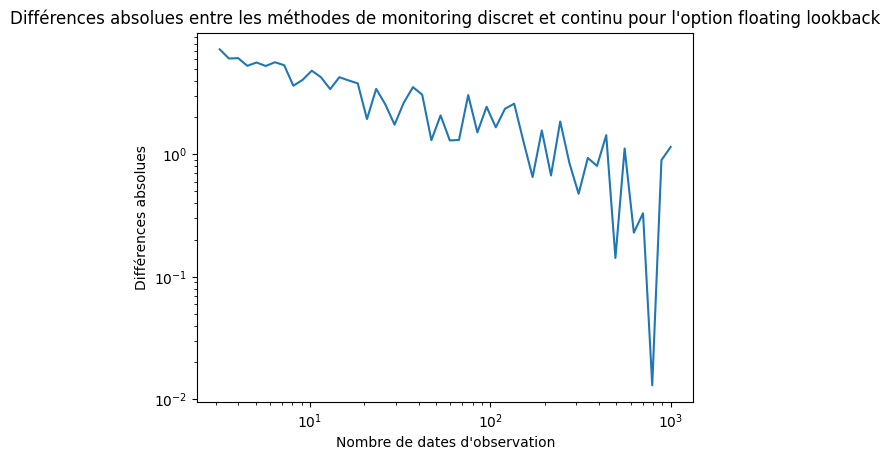

In [14]:
differences_look = np.abs(lookback_floating_strike_discrete - lookback_floating_strike_continuous)
plt.plot(obs_values, differences_look)
plt.yscale("log")
plt.xscale("log")
plt.xlabel('Nombre de dates d\'observation')
plt.ylabel('Différences absolues')
plt.title("Différences absolues entre les méthodes de monitoring discret et continu pour l\'option floating lookback")
plt.show()

La convergence du prix Monte Carlo de l’option d’achat à strike flottant quand le nombre de dates d’observation augmente vers le prix Monte Carlo avec monitoring continu du maximum est bien respectée.

# EDP

Quid de l'intégration numérique sur un domaine triangulaire...